In [1]:
import numpy as np
import pandas as pd
np.random.seed(0)

from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold, cross_val_score, cross_validate, cross_val_predict
from sklearn.dummy import DummyClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
    
from IPython.display import display
import ipywidgets as widgets

import xgboost as xgb 
import lightgbm as lgb
import catboost as ctb
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold, cross_val_score, cross_validate, cross_val_predict
from sklearn.utils import resample

from functools import partial
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials

import scikitplot as skplt #przydatna biblioteka do wizualizacji

import brewer2mpl #mapa kolorów
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
train = pd.read_csv('C:/Users/ja/Desktop/Data science od podstaw/titanic/train.csv')
test = pd.read_csv('C:/Users/ja/Desktop/Data science od podstaw/titanic/test.csv')

Pclass – klasa | (1 = pierwsza; 2 = druga; 3 = trzecia).
Name – imię i nazwisko pasażera.
Sex – płeć pasażera.
Sibsp – liczba małżonków, lub rodzeństwa na pokładzie.
Parch – liczba rodziców, lub dzieci na pokładzie.
Ticket – numer biletu.
Fare – opłata za bilet.
Cabin – kabina.
Embarked – port startowy (C = Cherbourg; Q = Queenstown; S = Southampton).

In [3]:
train.sample(10)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
495,496,0,3,"Yousseff, Mr. Gerious",male,NaN,0,0,2627,14.4583,NaN,C
648,649,0,3,"Willey, Mr. Edward",male,NaN,0,0,S.O./P.P. 751,7.5500,NaN,S
278,279,0,3,"Rice, Master. Eric",male,7.0,4,1,382652,29.1250,NaN,Q
31,32,1,1,"Spencer, Mrs. William Augustus (Marie Eugenie)",female,NaN,1,0,PC 17569,146.5208,B78,C
255,256,1,3,"Touma, Mrs. Darwis (Hanne Youssef Razi)",female,29.0,0,2,2650,15.2458,NaN,C
298,299,1,1,"Saalfeld, Mr. Adolphe",male,NaN,0,0,19988,30.5000,C106,S
609,610,1,1,"Shutes, Miss. Elizabeth W",female,40.0,0,0,PC 17582,153.4625,C125,S
318,319,1,1,"Wick, Miss. Mary Natalie",female,31.0,0,2,36928,164.8667,C7,S
484,485,1,1,"Bishop, Mr. Dickinson H",male,25.0,1,0,11967,91.0792,B49,C
367,368,1,3,"Moussa, Mrs. (Mantoura Boulos)",female,NaN,0,0,2626,7.2292,NaN,C


In [4]:
test.sample(10)

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
331,1223,1,"Dulles, Mr. William Crothers",male,39.0,0,0,PC 17580,29.7000,A18,C
366,1258,3,"Caram, Mr. Joseph",male,NaN,1,0,2689,14.4583,NaN,C
233,1125,3,"Linehan, Mr. Michael",male,NaN,0,0,330971,7.8792,NaN,Q
52,944,2,"Hocking, Miss. Ellen Nellie""""",female,20.0,2,1,29105,23.0000,NaN,S
302,1194,2,"Phillips, Mr. Escott Robert",male,43.0,0,1,S.O./P.P. 2,21.0000,NaN,S
297,1189,3,"Samaan, Mr. Hanna",male,NaN,2,0,2662,21.6792,NaN,C
198,1090,2,"Baimbrigge, Mr. Charles Robert",male,23.0,0,0,C.A. 31030,10.5000,NaN,S
6,898,3,"Connolly, Miss. Kate",female,30.0,0,0,330972,7.6292,NaN,Q
405,1297,2,"Nourney, Mr. Alfred (Baron von Drachstedt"")""",male,20.0,0,0,SC/PARIS 2166,13.8625,D38,C
214,1106,3,"Andersson, Miss. Ida Augusta Margareta",female,38.0,4,2,347091,7.7750,NaN,S


In [5]:
train['add_info'] = 'train'
test['add_info'] = 'test'
df = pd.concat([train, test], axis=0)

założenie - przeżyło więcej kobiet i osób z pierwszej klasy

In [6]:
#train.pivot_table(values=["Survived"], index=["Pclass","Sex"], aggfunc=np.mean)

In [10]:
def check_missing(df):
    for column in df.columns:
        missing = column, df[column].isnull().sum()
        if missing[1] == 0: continue

        print(missing)
        
check_missing(df)

('Survived', 418)
('Age', 263)
('Fare', 1)
('Cabin', 1014)
('Embarked', 2)


In [11]:
titles = set()
for name in df['Name']:
    titles.add(name.split(',')[1].split('.')[0].strip())
print(titles)

{'Col', 'Sir', 'Master', 'Don', 'Jonkheer', 'Rev', 'the Countess', 'Miss', 'Ms', 'Lady', 'Capt', 'Dona', 'Mr', 'Mlle', 'Major', 'Mrs', 'Dr', 'Mme'}


In [12]:
title_dict = {
    'Mr':'Mr',
    'Sir':'Royalty',
    'Dr':'Dr',
    'Rev':'Rev',
    'Ms':'Mrs',
    'Miss':'Miss',
    'Don':'Royalty',
    'Lady':'Royalty',
    'Mrs':'Mrs',
    'the Countess':'Royalty',
    'Col': 'Officer',
    'Jonkheer': 'Royalty',
    'Capt':'Officer',
    'Mme':'Mrs',
    'Major':'Officer',
    'Mlle':'Miss',
    'Master':'Master',
    'Dona': 'Royalty'
}

def get_titles():
    df['Title'] = df['Name'].map(lambda name:name.split(',')[1].split('.')[0].strip())
    df['Title'] = df.Title.map(title_dict)
    return df

In [13]:
get_titles()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,add_info,Title
0,1,0.0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,train,Mr
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,train,Mrs
2,3,1.0,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,train,Miss
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,train,Mrs
4,5,0.0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,train,Mr
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
413,1305,NaN,3,"Spector, Mr. Woolf",male,NaN,0,0,A.5. 3236,8.0500,NaN,S,test,Mr
414,1306,NaN,1,"Oliva y Ocana, Dona. Fermina",female,39.0,0,0,PC 17758,108.9000,C105,C,test,Royalty
415,1307,NaN,3,"Saether, Mr. Simon Sivertsen",male,38.5,0,0,SOTON/O.Q. 3101262,7.2500,NaN,S,test,Mr
416,1308,NaN,3,"Ware, Mr. Frederick",male,NaN,0,0,359309,8.0500,NaN,S,test,Mr


In [14]:
df['Title_cat'] = df['Title'].factorize()[0]

In [15]:
grouped_df = df.groupby(['Sex','Pclass','Title'])
grouped_median_df = grouped_df.median()
grouped_median_df = grouped_median_df.reset_index()[['Sex', 'Pclass', 'Title', 'Age']]

grouped_median_df.head()

,Sex,Pclass,Title,Age
0,female,1,Dr,49.0
1,female,1,Miss,30.0
2,female,1,Mrs,45.0
3,female,1,Royalty,39.0
4,female,2,Miss,20.0


In [16]:
def fill_age(row):
    condition = (
        (grouped_median_df['Sex'] == row['Sex']) & 
        (grouped_median_df['Title'] == row['Title']) & 
        (grouped_median_df['Pclass'] == row['Pclass'])
    ) 
    return grouped_median_df[condition]['Age'].values[0]


def transform_age():
    global df
    df['Age'] = df.apply(lambda row: fill_age(row) if np.isnan(row['Age']) else row['Age'], axis=1)
    return df

df = transform_age()

In [17]:
Fare_mean = train['Fare'].mean()
print(Fare_mean)
df['Fare'] = df['Fare'].fillna(Fare_mean)  #filling missing data (1 missing value) with mean of fare in train set

32.2042079685746


In [18]:
train['Embarked'].value_counts() #checking most common value to fill missing data (2 missing values)

S    644
C    168
Q     77
Name: Embarked, dtype: int64

In [19]:
df['Embarked'] = df['Embarked'].fillna('S') #most common value is S

In [20]:
df['Cabin'] = df['Cabin'].fillna('U') #fill missing values with Unknown (U)

In [21]:
df['Family_size'] = df['SibSp'] + df['Parch'] + 1
def family_cat(row):
    if row['Family_size'] == 1: return 0 #no family
    elif row['Family_size'] > 1 and row['Family_size'] <= 4: return 1 #small family
    else: return 2 #big family
df['Family_cat'] = df[['Family_size']].apply(family_cat, axis=1)

In [22]:
def is_mother(row):
    if row['Parch'] >=1 and row['Sex'] == 'female' and row['Age'] > 18: return 1
    else: return 0
df['Mother'] = df[['Parch', 'Sex', 'Age']].apply(is_mother, axis=1)

In [23]:
def is_adult(row):
    if row['Age'] > 18: return 1
    else: return 0
df['Adult'] = df[['Age']].apply(is_adult, axis=1)

In [24]:
check_missing(df)

('Survived', 418)


In [25]:
factorize_feats = ['Sex', 'Embarked']
for feat in factorize_feats:
    df["{}_cat".format(feat)] = df[feat].factorize()[0]
    
cabins = set()
for x in df['Cabin']:
    cabins.add(x[0])
df['Cabin_letter'] = df['Cabin'].map(lambda x: x[0])
df['Cabin_cat'] = df['Cabin_letter'].factorize()[0]

In [26]:
df

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,...,Title,Title_cat,Family_size,Family_cat,Mother,Adult,Sex_cat,Embarked_cat,Cabin_letter,Cabin_cat
0,1,0.0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,...,Mr,0,2,1,0,1,0,0,U,0
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,...,Mrs,1,2,1,0,1,1,1,C,1
2,3,1.0,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,...,Miss,2,1,0,0,1,1,0,U,0
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,...,Mrs,1,2,1,0,1,1,0,C,1
4,5,0.0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,...,Mr,0,1,0,0,1,0,0,U,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
413,1305,NaN,3,"Spector, Mr. Woolf",male,26.0,0,0,A.5. 3236,8.0500,...,Mr,0,1,0,0,1,0,0,U,0
414,1306,NaN,1,"Oliva y Ocana, Dona. Fermina",female,39.0,0,0,PC 17758,108.9000,...,Royalty,4,1,0,0,1,1,1,C,1
415,1307,NaN,3,"Saether, Mr. Simon Sivertsen",male,38.5,0,0,SOTON/O.Q. 3101262,7.2500,...,Mr,0,1,0,0,1,0,0,U,0
416,1308,NaN,3,"Ware, Mr. Frederick",male,26.0,0,0,359309,8.0500,...,Mr,0,1,0,0,1,0,0,U,0


In [27]:
train = df[df['add_info'] == 'train']
test = df[df['add_info'] == 'test']

In [28]:
#sprawdzenie na zbiorze treningowym

feats = ['Pclass', 'Age', 'Fare', 'Sex_cat', 'Cabin_cat', 'Title_cat', 'Family_cat', 'Mother', 'Adult']

X = train[feats].values
y = train['Survived'].values

#model = DecisionTreeClassifier(max_depth=3, random_state=2019)
#model = LogisticRegression(random_state=2019)
model = RandomForestClassifier(max_depth=10, n_estimators=10, random_state=2019)
#model = RandomForestClassifier(max_features=4, max_leaf_nodes= 76,max_depth= 9, min_weight_fraction_leaf= 0.2,
#   random_state= 50)
#model = xgb.XGBClassifier(colsample_bytree=0.8080732897369698,   learning_rate= 0.1662160602526227,   max_depth=20,
#   min_child_weight= 1,   random_state= 9950,   reg_alpha= 2.51071059134118,   reg_lambda= 0.9138474857858827,
#   subsample= 0.9899984284983565)
#model = lgb.LGBMClassifier(n_estimators=100, random_state=0)
#model = ctb.CatBoostClassifier(n_estimators=20, depth=10, verbose=False, random_state=0)

cv = KFold(n_splits=4)

scores = []
for train_idx, test_idx in cv.split(X):
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]

    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    score = accuracy_score(y_test, y_pred)
    scores.append( score )
    
    
print(np.mean(scores), np.std(scores))
print(score)
print(scores)

0.8294095665171899 0.011363864872597133
0.8333333333333334
[0.8430493273542601, 0.8295964125560538, 0.8116591928251121, 0.8333333333333334]


In [29]:
def run_cv_model(model_cls, model_params, X, y, feats, cv=4, scoring='accuracy', plot_learning_curve=True, plot_confusion_matrix=True, plot_feature_importances=True):

    scores = cross_val_score(model_cls(**model_params), X, y, cv=cv, scoring=scoring)
    print('mean={}, std={}, scores={}'.format( np.round(np.mean(scores), 2), np.round(np.std(scores), 2), scores))
    
    model = None
    if plot_learning_curve:
        model = model_cls(**model_params)
        model.fit(X, y)
        title='Learning Curve. {0}: {1}'.format(model_cls.__name__, model_params)
        skplt.estimators.plot_learning_curve(model, X, y, title=title,figsize=(15, 5), cv=cv, scoring=scoring);
    
    if plot_confusion_matrix:
        y_pred = cross_val_predict(model_cls(**model_params), X, y, cv=cv)
        title='Confusion Matrix. {0}: {1}'.format(model_cls.__name__, model_params)
        skplt.metrics.plot_confusion_matrix(y, y_pred, title=title, normalize=True, figsize=(20 ,10))
    
    if plot_feature_importances:
        if model is None:
            model = model_cls(**model_params)
            model.fit(X, y)
        title='Feature Importance. {0}: {1}'.format(model_cls.__name__, model_params)
        skplt.estimators.plot_feature_importances(model, feature_names=feats, title=title, x_tick_rotation=90, figsize=(15, 5));    

mean=0.82, std=0.03, scores=[0.78026906 0.85650224 0.81165919 0.81981982]


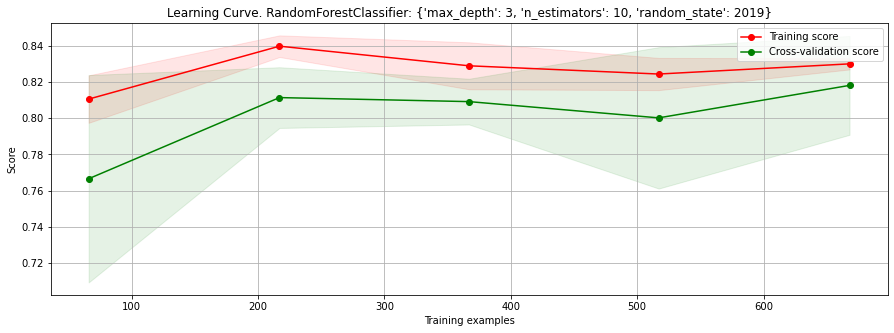

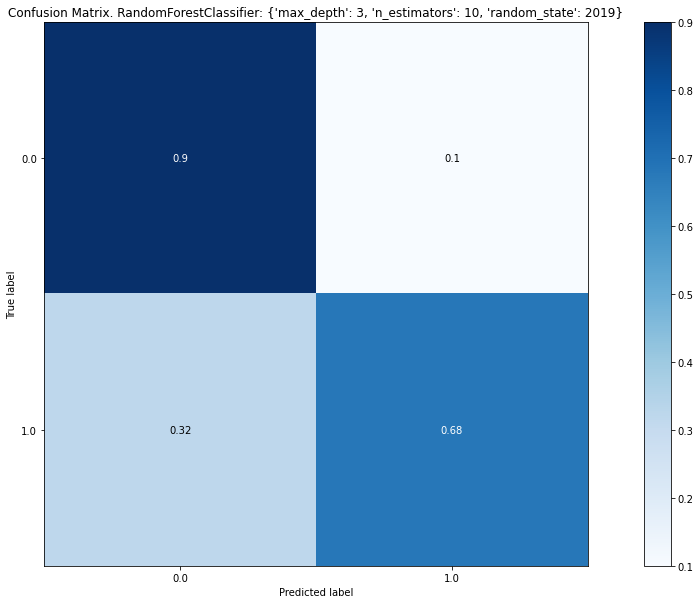

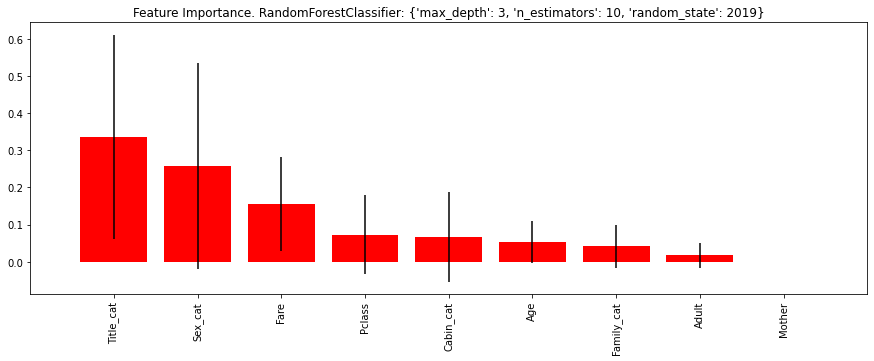

In [30]:
run_cv_model(RandomForestClassifier, {'max_depth':3, 'n_estimators':10, 'random_state':2019}, X,y, feats)

In [31]:
def objective(space):
    
    RFC_params = {
        'max_depth': int(space['max_depth']),
        'min_weight_fraction_leaf': int(space['min_weight_fraction_leaf']),
        'max_features': int(space['max_features']),
        'max_leaf_nodes': int(space['max_leaf_nodes']),
        'n_estimators': 100,
    }
        
    model = RandomForestClassifier(**RFC_params, random_state=2019)
    cv = KFold(n_splits=4, random_state=2019, shuffle=True)
    for train_idx, test_idx in cv.split(y):
        model.fit(X[train_idx], y[train_idx])
        y_pred = model.predict(X[test_idx])
        
    #model.fit(X[train_idx], y[train_idx])
    #y_pred = model.predict(X[test_idx])
        score = accuracy_score(y[test_idx], y_pred)
    
    return{'loss': -score, 'status': STATUS_OK }
    
space ={
    'max_depth': hp.quniform ('x_max_depth', 5, 20, 1),
    'random_state': hp.quniform ('x_random_state', 0, 10000, 50),
    'min_weight_fraction_leaf': hp.quniform ('x_min_weight_fraction_leaf', 0, 0.9, 0.1),
    'max_features': hp.quniform ('max_features', 1, 9, 1),
    'max_leaf_nodes': hp.quniform ('max_leaf_nodes', 2, 100, 1),
}


trials = Trials()
best_params = fmin(fn=objective,
            space=space,
            algo=partial(tpe.suggest, n_startup_jobs=1),
            max_evals=30,
            trials=trials)

print("The best params: ", best_params)

100%|██████████| 30/30 [00:20<00:00,  1.48trial/s, best loss: -0.8513513513513513]
The best params:  {'max_features': 4.0, 'max_leaf_nodes': 68.0, 'x_max_depth': 8.0, 'x_min_weight_fraction_leaf': 0.1, 'x_random_state': 9950.0}


In [32]:
trials.best_trial

{'state': 2,
 'tid': 27,
 'spec': None,
 'result': {'loss': -0.8513513513513513, 'status': 'ok'},
 'misc': {'tid': 27,
  'cmd': ('domain_attachment', 'FMinIter_Domain'),
  'workdir': None,
  'idxs': {'max_features': [27],
   'max_leaf_nodes': [27],
   'x_max_depth': [27],
   'x_min_weight_fraction_leaf': [27],
   'x_random_state': [27]},
  'vals': {'max_features': [4.0],
   'max_leaf_nodes': [68.0],
   'x_max_depth': [8.0],
   'x_min_weight_fraction_leaf': [0.1],
   'x_random_state': [9950.0]}},
 'exp_key': None,
 'owner': None,
 'version': 0,
 'book_time': datetime.datetime(2021, 10, 22, 10, 25, 43, 957000),
 'refresh_time': datetime.datetime(2021, 10, 22, 10, 25, 44, 619000)}

mean=0.78, std=0.02, scores=[0.75336323 0.80717489 0.78026906 0.76576577]


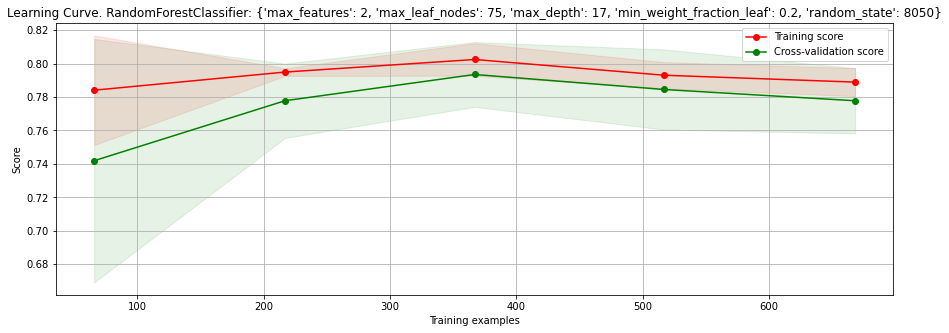

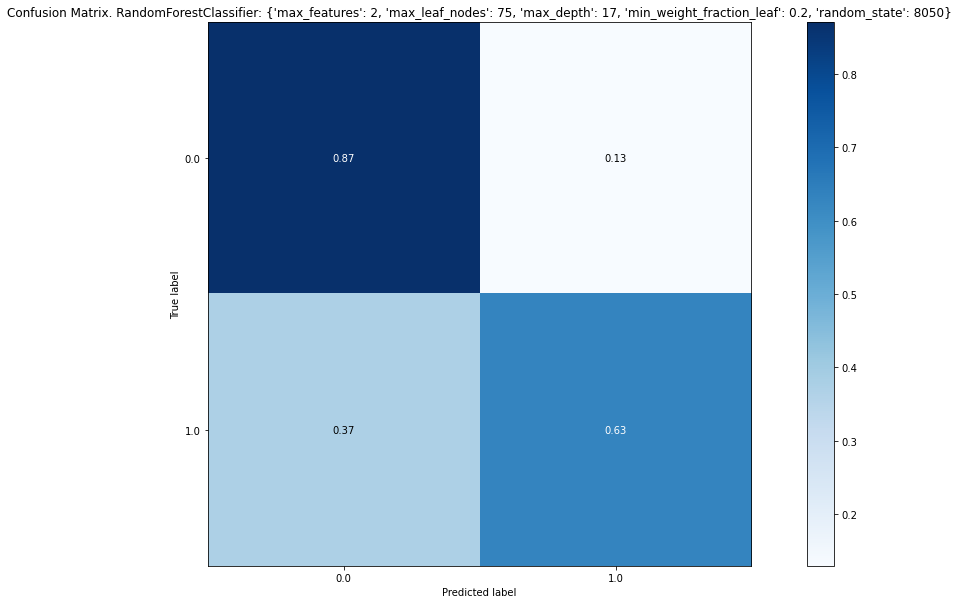

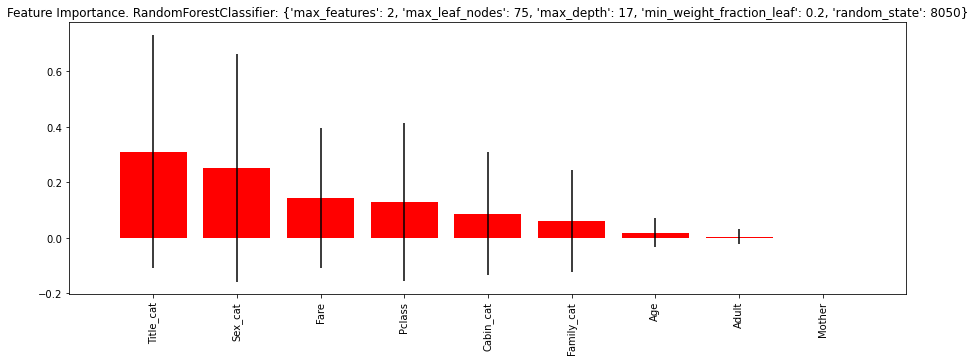

In [33]:
run_cv_model(RandomForestClassifier, {'max_features': 2, 'max_leaf_nodes': 75,'max_depth': 17, 'min_weight_fraction_leaf': 0.2,
   'random_state': 8050}, X,y, feats)

In [34]:
X_test = test[feats].values
model.fit(X, y)
y_pred = model.predict(X_test)

In [97]:
print("save file")
test['Survived'] = y_pred
test['Survived'] = test['Survived'].astype(np.int)
test[ ['PassengerId', 'Survived'] ].to_csv('gender_submission.csv', index=False) 

save file


<ipython-input-97-bbe0ff6cfac3>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['Survived'] = y_pred
<ipython-input-97-bbe0ff6cfac3>:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  test['Survived'] = test['Survived'].astype(np.int)
<ipython-input-97-bbe0ff6cfac3>:3: SettingWithCopyWarning: 
A value i

In [98]:
test[ ['PassengerId', 'Survived'] ]
submission = test[ ['PassengerId', 'Survived'] ]
submission

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1
...,...,...
413,1305,0
414,1306,1
415,1307,0
416,1308,0
